## Sleep Quality Prediction - Supervised Machine Learning

---

by: Cody Hill

date: 1/18/2024

This project is intended for building machine learning predictive models on Oura Ring exported data. Since the data collection period is currently limited, this notebook is being built with the goal of continued data uploads (all data cleaning/analysis will be generalized for continuous new data).

### Data Source Information
All data has been exported from my personal Oura Ring on January 18, 2024 containing raw biometric data and Oura calculated data since I began wearing the device.
- Data collection starting 2/3/2023 to 1/18/2024 (last upload)
- [ Data explanations (URL to Oura?)]
### [ ADD LICENSE INFORMATION AND FAIR USE INFO ]

**TODO: oura_sleep_2024-01.csv**
- [X] Nap on day encoding
  - [X] `list(where ['type'] != long_sleep && between 10 AM - 7 PM)`
       Does the nap affect day of or next day? I chose day of
  - [X] sum(types of sleep duration)
- [ ] restless_periods vs sum(movement_30_sec) ??
- [X] Only one day per entry
  - [X] Sum each day sleep durations, restless_periods, awake_time, time_in_bed, total_sleep_duration
  - [X] `awake_time = time_in_bed - total_sleep_duration` ??
- [X] Save only the `['type'] == long_sleep, average_breath, average_heart_rate, average_hrv, latency, 
       lowest_heart_rate, betime_start_delta`
- [X] Remove: `efficiency, period, score, segment_state, sleep_midpoint, sleep_phase_5_min, movement_30_sec, timezone, 
       betime_end_delta, midpoint_at_delta, heart_rate_5_min, hrv_5_min`

**TODO: oura_daily-activity_2024-01.csv**
- [X] Remove: `average_met_minutes, equivalent_walking_distance, high_activity_met_minutes, inactivity_alerts, 
       low_activity_met_minutes, medium_activity_met_minutes, sedentary_met_minutes, target_calories, target_meters, score,
       class_5_min, met_1_min, ring_met_1_min`
- [ ] Workout daily boolean (Maybe unnecessary with other metrics compare models w/ and w/o)
- [X] Assign all activity to previous day???

**TODO: oura_daily-readiness_2024-01.csv**
- [X] Remove: `score, temperature_trend_deviation`

**TODO: oura_daily--spo2_2024-01.csv**
- [X] Deal with NaNs

**TODO: General**
- [X] Collinearity between features checks in model selection
- [X] Feature standardization/normalization
- [ ] Create Readme
- [ ] Print systeminfo output
- [ ] Reroute filepath to github url
- [ ] Deal with NaNs using a generalized method
- [ ] Bin the Ys!
  - [X] Even-width bins
  - [ ] Quantile bin method
- [X] Balance train and test split classes? Note: Only works with more data, currently remove outliers (when class n < 2)
- [X] Implement regression friendly dataframe.
- [ ] ROC Curve or F1
- [ ] Previous Day's Sleep Score feature (assuming previous day sleep affects current day)
- [ ] oversampling/SMOTE 
- [X] Different models
- [X] Reduce Features
  - [X] Correlation matrix
  - [ ] Recursive solution: forward, backward, best subset
  - [ ] sklearn.feature_selection >> RFE

In [655]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

### Setup and Data Cleaning

In [656]:
# Import data
# TODO: Switch this to the github urls for the data so others can use.
data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data'
sleep_data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data/Sleep_Data'

# Iterate through each file in .Data/ and add it to a dataframe.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
# Using a list to concat the dfs with index_col allows to easily merge based on 'day'. More memory usage but fine for this project.
biometric_df = pd.concat([pd.read_csv(file, index_col = 'day') for file in file_path], join = 'outer', ignore_index = False, axis = 1).reset_index()

# Iterate through each file in .Data/Sleep_Data and add it to a dataframe.
# Separated sleep data as it potentially has multiple entries per day. Will merge them later.
file_path_sleep = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' not in file]
sleep_df = pd.concat(map(pd.read_csv, file_path_sleep), join = 'outer', ignore_index = False, axis = 1)

# Import ground truth label sleep score.
file_path_daily_sleep_score = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' in file]
daily_sleep_score_df = pd.read_csv(file_path_daily_sleep_score[0])
daily_sleep_score_df = daily_sleep_score_df[['score', 'day']]

In [657]:
# First looks
print('biometric_df info:\n------------------\n', biometric_df.shape)
display(biometric_df.head(2))
print(biometric_df.columns)
print('\n\nsleep_df info:\n------------------\n', sleep_df.shape)
display(sleep_df.head(4))
print(sleep_df.columns)

biometric_df info:
------------------
 (350, 42)


,day,spo2_percentage,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,...,temperature_deviation,temperature_trend_deviation,contributors_activity_balance,contributors_hrv_balance,contributors_previous_day_activity,contributors_previous_night,contributors_recovery_index,contributors_resting_heart_rate,contributors_sleep_balance,contributors_body_temperature
0,2023-02-04,98.523,650,1.59375,10728,16,120,0,277,23220,...,-0.38,NaN,NaN,NaN,96.0,74.0,97.0,94.0,NaN,90.0
1,2023-02-05,97.181,498,1.43750,8458,8,60,0,204,15000,...,-0.04,0.15,NaN,NaN,82.0,79.0,100.0,59.0,NaN,100.0


Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'score',
       'class_5_min', 'contributors_meet_daily_targets',
       'contributors_move_every_hour', 'contributors_recovery_time',
       'contributors_stay_active', 'contributors_training_frequency',
       'contributors_training_volume', 'met_1_min', 'ring_met_1_min', 'score',
       'temperature_deviation', 'temperature_trend_deviation',
       'contributors_activity_balance', 'contributors_hrv_balance',
       'contributors_previous_day_activity', 'contributors_previous_night',
       'contributors_recov

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,efficiency,latency,...,readiness_contributors_body_temperature,readiness_contributors_hrv_balance,readiness_contributors_previous_day_activity,readiness_contributors_previous_night,readiness_contributors_recovery_index,readiness_contributors_resting_heart_rate,readiness_contributors_sleep_balance,readiness_score,readiness_temperature_deviation,readiness_temperature_trend_deviation
0,13.625,63.25,77.0,4440.0,2023-02-04T07:08:22.000-06:00,2023-02-03T22:40:22.000-06:00,2023-02-04,4650.0,85.0,990.0,...,90.0,NaN,96.0,74.0,97.0,94.0,NaN,89.0,-0.38,NaN
1,15.125,92.49,19.0,6210.0,2023-02-05T09:37:28.000-06:00,2023-02-04T23:54:28.000-06:00,2023-02-05,4590.0,82.0,180.0,...,100.0,NaN,82.0,79.0,100.0,59.0,NaN,78.0,-0.04,0.15
2,15.125,87.67,NaN,1920.0,2023-02-05T20:10:57.000-06:00,2023-02-05T19:36:57.000-06:00,2023-02-06,30.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.125,82.50,37.0,720.0,2023-02-05T20:36:02.000-06:00,2023-02-05T20:20:02.000-06:00,2023-02-06,0.0,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'score', 'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_duration', 'type', 'sleep_phase_5_min', 'timezone',
       'bedtime_start_delta', 'bedtime_end_delta', 'midpoint_at_delta',
       'heart_rate_5_min', 'hrv_5_min', 'contributors_total_sleep',
       'contributors_deep_sleep', 'contributors_rem_sleep',
       'contributors_efficiency', 'contributors_latency',
       'contributors_restfulness', 'contributors_timing',
       'readiness_contributors_activity_balance',
       'readiness_contributors_body_temperature',
       'readiness_contributors_hrv_balance',
       'readiness_contributors_previous_day_activity',
       'readiness_contributors_previous_night'

As we can see, the Oura Ring tracks and records quite a few biometrics, and with that raw biometric data they also are feature engineering and calculating new metrics to assign a daily score to categories such as sleep, recovery, readiness, activity, etc. totalling 89 features.

Since the purpose of this is to create our own sleep score predictive model, we can use Oura's sleep score as our ground truth label (y_train) in training and validation. Furthermore, we must remove the features with labels that include "contributors" as these columns contain standardized scores which Oura's models have output that are then used to average out into the final score.

*Note:* Two dataframes have been intialized here because some of the data has one entry per day (`biometric_df`), but the sleep data potentially has multiple entries per day (`sleep_df`). This was done for ease of transforming the data later.

In [658]:
print('\n\ndaily_sleep_score_df info:\n--------------------------\n',daily_sleep_score_df.shape)
display(daily_sleep_score_df.head(4))



daily_sleep_score_df info:
--------------------------
 (336, 2)


,score,day
0,81,2023-02-04
1,81,2023-02-05
2,89,2023-02-06
3,78,2023-02-07


In [659]:
# Remove contributor and score columns (multiple scores involved, will add truth label later).
biometric_df = biometric_df.loc[:, ~biometric_df.columns.str.contains('contributors|score')]
sleep_df = sleep_df.loc[:, ~sleep_df.columns.str.contains('contributors|score')]

print(biometric_df.shape)
print(sleep_df.shape)

(350, 26)
(685, 30)


We've removed 33 feature columns containing the word 'contributors' (or 'score' since we'll be using the score in `daily_sleep_score_df`).

Let's take a closer look at the remaining features and continue further data preparations.

In [660]:
print(biometric_df.columns, sleep_df.columns)

Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'class_5_min',
       'met_1_min', 'ring_met_1_min', 'temperature_deviation',
       'temperature_trend_deviation'],
      dtype='object') Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_d

In [661]:
# Confirm there are no duplicates of days in the biometric data.
biometric_df['day'].duplicated().sum()

0

We'll be removing any features that don't seem relevant to our sleep score prediction models. For now we will not touch any potentially "overlapping" features that might introduce predictor collinearity issues, but will address them later.

We'll also take a look at the remaining features' data types and see if any data munging is necessary (formatting all the features (float, int, dates, dummy/indicator encoding)).

In [662]:
# Columns to drop
# sleep_df
drop_col_sleep = ['efficiency', 'period', 'segment_state',
            'sleep_midpoint', 'sleep_phase_5_min', 'movement_30_sec',
            'timezone', 'bedtime_end_delta', 'midpoint_at_delta',
            'heart_rate_5_min', 'hrv_5_min'] # timezone? -- might need during EDA
sleep_df.drop(drop_col_sleep, axis = 1, inplace = True)

# biometric_df
drop_col_bio = ['average_met_minutes', 'equivalent_walking_distance', 
                'high_activity_met_minutes', 'inactivity_alerts', 
                'low_activity_met_minutes', 'medium_activity_met_minutes', 
                'sedentary_met_minutes', 'target_calories', 
                'target_meters', 'class_5_min', 
                'met_1_min', 'ring_met_1_min', 
                'temperature_trend_deviation']
biometric_df.drop(drop_col_bio, axis = 1, inplace = True)

# Reformat date columns
date_col_sleep = ['bedtime_end', 'bedtime_start', 'day']
# All times reformatted to UTC
sleep_df[date_col_sleep] = sleep_df[date_col_sleep].apply(pd.to_datetime, utc = True, errors = 'coerce')
biometric_df['day'] = biometric_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')
daily_sleep_score_df['day'] = daily_sleep_score_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')

In [663]:
# Placeholder: testing for EDA using dropped timezone column
tzone = -240
f"{int(tzone / 10 / 6)}:00"

'-4:00'

In [664]:
print(biometric_df.dtypes)
print(sleep_df.dtypes)

day                      datetime64[ns, UTC]
spo2_percentage                      float64
active_calories                        int64
high_activity_time                     int64
low_activity_time                      int64
medium_activity_time                   int64
meters_to_target                       int64
non_wear_time                          int64
resting_time                           int64
sedentary_time                         int64
steps                                  int64
total_calories                         int64
temperature_deviation                float64
dtype: object
average_breath                                       float64
average_heart_rate                                   float64
average_hrv                                          float64
awake_time                                           float64
bedtime_end                              datetime64[ns, UTC]
bedtime_start                            datetime64[ns, UTC]
day                                

Everything above looks good, we can see that `['type']` is an object which likely means it's a string. Let's see what values it can take.

In [665]:
sleep_df['type'].unique()

array(['long_sleep', nan, 'late_nap', 'rest', 'sleep'], dtype=object)

We can use this information along with the time data in the next section to identify different periods of sleep.

Like was mentioned before, the `sleep_df` contains multiple entries per day which either is interrupted sleep during the night or afternoon naps. Eventually we need all the data in one dataframe but first we can engineer some features with this information. 

A reasonable solution seems to be to total all the sleep categories that occurred per day, accounting for sleep interruptions at night, and any naps counting towards that total as well. However, we will lose that nap information when we total the sleep times and it might also be beneficial to identify days in which naps occur using a binary boolean (0 = No Nap, 1 = Yes Nap), potentially increasing the sleep score. We will make a new feature with the sleep information before consolidation.

In [666]:
# Initialize a time frame we can consider a nap/rest period (UTC format).
nap_upper = pd.to_datetime('23:59:00').time()
nap_lower = pd.to_datetime('14:00:00').time()
# Condition on the start, end time, and total sleep duration to filter out false-positives, remove any long_sleep types.
nap_bool = ((sleep_df['bedtime_start'].dt.time >= nap_lower) & 
            (sleep_df['bedtime_end'].dt.time <= nap_upper) & 
            (sleep_df['total_sleep_duration'] > 600) &
            (sleep_df['type'] != 'long_sleep'))
print('Naps identified:\n')
display(sleep_df[nap_bool])
# Insert a nap_today column and binary yes/no for each day.
# Initialize column with zeroes.
sleep_df['nap_today'] = np.zeros_like(sleep_df.shape[0])
# Use boolean array to identify nap days and iterate through to change nap_today to 1.
# TODO: This is not the pandas way but is fine with this amount of data. Use a better method later.
# Something like, sleep_df['nap_today'].where(~nap_bool, 1, inplace = True) does not work in this situation..
# Need each entry for that day to = 1 not just the nap itself.
nap_days = sleep_df[nap_bool]['day']
for day in nap_days:
    sleep_df.loc[sleep_df['day'] == day, 'nap_today'] = 1

Naps identified:



,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,latency,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,time_in_bed,total_sleep_duration,type,bedtime_start_delta,readiness_temperature_deviation,readiness_temperature_trend_deviation
31,13.500,74.47,34.0,6270.0,2023-02-20 21:16:13+00:00,2023-02-20 19:05:13+00:00,2023-02-20 00:00:00+00:00,420.0,570.0,840.0,67.0,330.0,25.0,7860,1590.0,NaN,47113,NaN,NaN
34,13.875,70.14,58.0,3540.0,2023-02-21 23:27:03+00:00,2023-02-21 21:59:03+00:00,2023-02-21 00:00:00+00:00,120.0,3600.0,1140.0,60.0,480.0,23.0,5280,1740.0,NaN,57543,NaN,NaN
44,14.750,90.50,25.0,3690.0,2023-02-27 01:11:23+00:00,2023-02-26 23:54:23+00:00,2023-02-27 00:00:00+00:00,300.0,2760.0,540.0,90.0,90.0,24.0,4620,930.0,NaN,60863,NaN,NaN
53,14.750,NaN,NaN,1140.0,2023-03-01 23:27:00+00:00,2023-03-01 22:51:00+00:00,2023-03-01 00:00:00+00:00,570.0,750.0,420.0,NaN,30.0,11.0,2160,1020.0,NaN,60660,NaN,NaN
63,14.625,71.67,NaN,930.0,2023-03-06 22:03:32+00:00,2023-03-06 21:30:32+00:00,2023-03-06 00:00:00+00:00,630.0,390.0,420.0,70.0,0.0,31.0,1980,1050.0,NaN,55832,NaN,NaN
88,13.750,65.15,75.0,1530.0,2023-03-17 21:33:33+00:00,2023-03-17 20:17:33+00:00,2023-03-17 00:00:00+00:00,90.0,450.0,2940.0,62.0,0.0,88.0,4560,3030.0,NaN,55053,NaN,NaN
89,13.750,68.33,63.0,2070.0,2023-03-17 23:52:33+00:00,2023-03-17 22:48:33+00:00,2023-03-18 00:00:00+00:00,540.0,1410.0,780.0,63.0,450.0,12.0,3840,1770.0,late_nap,64113,NaN,NaN
116,13.625,70.40,70.0,3030.0,2023-03-30 20:27:01+00:00,2023-03-30 19:26:01+00:00,2023-03-30 00:00:00+00:00,180.0,690.0,450.0,68.0,0.0,10.0,3660,630.0,NaN,51961,NaN,NaN
152,14.125,61.20,107.0,750.0,2023-04-23 21:10:49+00:00,2023-04-23 20:29:49+00:00,2023-04-23 00:00:00+00:00,1260.0,330.0,450.0,56.0,0.0,15.0,2460,1710.0,sleep,55789,NaN,NaN
180,14.875,71.20,80.0,1080.0,2023-05-10 18:45:42+00:00,2023-05-10 17:44:42+00:00,2023-05-10 00:00:00+00:00,810.0,570.0,1770.0,67.0,0.0,29.0,3660,2580.0,sleep,45882,NaN,NaN


Continuing to setup our feature dataframe, the day in which the biometric data is being collected will affect the next day. Currently, and maybe obviously, the sleep score is recorded on the day you wake on, meaning each date is referencing the previous night's sleep. This is important to note because the features we're left with in the `biometric_df` is being collected on the day in which a sleep score has already been recorded (e.g., calories burned, steps, heart rate, etc). Logically this data is more relevant to the upcoming night's sleep, therefore, since we're organizing metrics per day, we need to shift this date 1 day to align with our model's target/response variable (sleep score).

*Example:*

**Original**
| Score | Day (sleep_df) | Bedtime Start | Bedtime End | / | / | Day (biometric_df) | Steps | Active Calories |
|-------|-----|---------------|-------------|---|---|-----|-------|-----------------|
|...|...|...|...|/|/|...|...|...|
| 81 | 01/20/2024 | 1/19/2024 22:30 | 1/20/2024 07:00 |/|/| 01/20/2024 | 13000 | 800 |
| 65 | 01/21/2024 | 1/20/2024 23:45 | 1/21/2024 05:20 |/|/| 01/21/2024 | 21000 | 1900 |
|...|...|...|...|/|/|...|...|...|

**New DF** - Shifted biometric data to next day, aligning with relevant sleep score.
| Score | Day (sleep_df) | Bedtime Start | Bedtime End | / | / | ~~Day (biometric_df)~~ | Steps | Active Calories |
|-------|-----|---------------|-------------|---|---|-----|-------|-----------------|
| 81 | 01/20/2024 | 1/19/2024 22:30 | 1/20/2024 07:00 |/|/|$\Downarrow$ ~~01/19/2024~~ |$\Downarrow$ 14000 |$\Downarrow$ 600 |
| 65 | 01/21/2024 | 1/20/2024 23:45 | 1/21/2024 05:20 |/|/|$\Downarrow$ ~~01/20/2024~~ |$\Downarrow$ 13000 |$\Downarrow$ 800 |
| 73 | 01/22/2024 | 1/21/2024 23:00 | 1/22/2024 07:20 |/|/|$\Downarrow$ ~~01/21/2024~~ |$\Downarrow$ 21000 |$\Downarrow$ 1900 |

In [667]:
# Shift day one day into the future to align with relevant sleep score day.
biometric_df['day'] = biometric_df['day'] + pd.DateOffset(days = 1)
# Remove last day in biometric dataset since it won't have a sleep score with day shifting.
bio_max_idx = biometric_df.loc[biometric_df['day'] == biometric_df['day'].max()].index
biometric_df.drop(index = bio_max_idx, axis = 0, inplace = True)

# Verify each dataframe starts and ends on the same day.
print('Earliest Dates in each DF:')
print(biometric_df['day'].min(), '<-- biometric_df')
print(sleep_df['day'].min(), '<-- sleep_df')
print(daily_sleep_score_df['day'].min(), '<-- daily_sleep_score_df')
print('\nLatest Dates in each DF:')
print(biometric_df['day'].max(), '<-- biometric_df')
print(sleep_df['day'].max(), '<-- sleep_df')
print(daily_sleep_score_df['day'].max(), '<-- daily_sleep_score_df')

Earliest Dates in each DF:
2023-02-04 00:00:00+00:00 <-- biometric_df
2023-02-04 00:00:00+00:00 <-- sleep_df
2023-02-04 00:00:00+00:00 <-- daily_sleep_score_df

Latest Dates in each DF:
2024-01-18 00:00:00+00:00 <-- biometric_df
2024-01-18 00:00:00+00:00 <-- sleep_df
2024-01-18 00:00:00+00:00 <-- daily_sleep_score_df


In [668]:
# Identify days where there wasn't a long period of sleep
sleep_df_long = sleep_df.loc[sleep_df['type'] == 'long_sleep']

# Use merge() to find the differences in dataframes indicating days that didn't record a long sleep.
# Requires a method where the two df indexes don't match.
# Credit to: https://stackoverflow.com/questions/48647534/find-difference-between-two-data-frames
no_sleep = pd.DataFrame(sleep_df['day']).merge(sleep_df_long['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']
print('Entries in which no long periods of sleep were recorded that day:')
display(no_sleep)

# We can remove these days with no long_sleep from the main dataframes as they won't have sleep scores anyways.
    # Sleep DF
sleep_df.drop(no_sleep.index, axis = 0, inplace = True)

    # Biometric DF
    # We can use our previous work and just remove the days that the two DFs don't share.
no_sleep_bio_days =  pd.DataFrame(biometric_df['day']).merge(sleep_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day']
no_sleep_bio_index = biometric_df[biometric_df['day'].isin(no_sleep_bio_days)].index
biometric_df.drop(no_sleep_bio_index, axis = 0, inplace = True)

    # Daily Sleep Score DF
no_sleep_score_index = pd.DataFrame(daily_sleep_score_df['day']).merge(biometric_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day'].index
daily_sleep_score_df.drop(index = no_sleep_score_index, axis = 0, inplace = True)
    # We can now remove the day column from the daily_sleep_score_df
daily_sleep_score_df.drop(['day'], axis = 1, inplace = True)

Entries in which no long periods of sleep were recorded that day:


,day,_merge
103,2023-03-24 00:00:00+00:00,left_only
140,2023-04-15 00:00:00+00:00,left_only
161,2023-05-01 00:00:00+00:00,left_only
162,2023-05-01 00:00:00+00:00,left_only
163,2023-05-02 00:00:00+00:00,left_only
173,2023-05-08 00:00:00+00:00,left_only
223,2023-05-28 00:00:00+00:00,left_only
224,2023-05-28 00:00:00+00:00,left_only
326,2023-07-24 00:00:00+00:00,left_only
402,2023-08-31 00:00:00+00:00,left_only


Another adjustment which might have potential benefit for different models is putting the sleep score into categorical variable bins. We will keep the discrete sleep score column for use in our models, but create another column which indicates which bin that score falls into for use in logistic regression or otherwise.

For now we will just create equal bin sizes with the width of 5. However, this creates rather arbitrary boundaries. Further improvements might be found by looking at the distribution of the scores and binning only from the min and max edges (would need to build a function to handle data-drift in case of new data) or using something like median-centered/quantile binning which makes more insight based bin edges and handles outliers better.

In [669]:
# Instead of having 0-100 potential label predictions we should create a categorical 'binned' label column.
# Create bins. We can use .5 to easily decide left edge or right edge issues.
bins = np.linspace(0.5, 100.5, 21, dtype = float)
bin_labels = [f"{i} to {i + 5}" for i in bins if i != bins[-1]]
# np.digitize() can map the sleep scores to the correct bins
bin_idx = np.digitize(daily_sleep_score_df['score'], bins, right = False)
# Create new column with the new bin labels
daily_sleep_score_df['score_bin'] = [bin_labels[value - 1] for value in bin_idx]
display(daily_sleep_score_df.tail(5))

,score,score_bin
331,77,75.5 to 80.5
332,85,80.5 to 85.5
333,64,60.5 to 65.5
334,77,75.5 to 80.5
335,71,70.5 to 75.5


Finally, now that we've extracted the features we wanted from `sleep_df`, we can total the multiple sleep entries per day and then combine the sleep metrics with the biometric data. 

*Note: some metrics are not summed in this process, and of those, only the metrics tied to the `'long_sleep'` entry will be used in the final dataset. (e.g., we don't really care what the average heart rate variability (`['average_hrv']`) or (`['latency']`) is for an interrupted sleep section during the night that only lasted 30 minutes.)*

In [670]:
# Sum each day's sleep metrics (important for days with interrupted sleep or naps).
# Overwrites each day's entry.
sleep_df = sleep_df[['day', 
         'deep_sleep_duration', 
         'light_sleep_duration', 
         'rem_sleep_duration', 
         'restless_periods', 
         'awake_time', 
         'time_in_bed', 
         'total_sleep_duration']].groupby(['day']).sum().reset_index()

# Features extracted only from the long sleep to include in the final dateframe.
sleep_df_long = sleep_df_long[['day', 
                               'average_breath', 
                               'average_heart_rate', 
                               'average_hrv', 
                               'latency', 
                               'lowest_heart_rate', 
                               'bedtime_start_delta',
                               'nap_today']]
# Merge the summed features with the long_sleep-only features.
sleep_df = sleep_df.merge(sleep_df_long, on = 'day', how = 'outer')
sleep_df.head(2)

,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,latency,lowest_heart_rate,bedtime_start_delta,nap_today
0,2023-02-04 00:00:00+00:00,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,990.0,56.0,-4778,0
1,2023-02-05 00:00:00+00:00,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,180.0,75.0,-332,0


Now that all feature cleaning, creation, and transformations are complete we should verify each dataframe matches shape for the upcoming merge.

In [671]:
print('Verify all DF.shape matches:', sleep_df.shape[0] == biometric_df.shape[0] == daily_sleep_score_df.shape[0])
print(sleep_df.shape, '<-- sleep_df')
print(biometric_df.shape, '<-- biometric_df')
print(daily_sleep_score_df.shape, '<-- daily_sleep_score_df')

Verify all DF.shape matches: True
(334, 15) <-- sleep_df
(334, 13) <-- biometric_df
(334, 2) <-- daily_sleep_score_df


Now, let's create one dataframe for the features and display them.

In [672]:
# Merge sleep and biometric DFs.
bio_sleep_df = sleep_df.merge(biometric_df, on = 'day', how = 'outer')
bio_sleep_df.drop(['day'], axis = 1, inplace = True)
display(bio_sleep_df)
print(bio_sleep_df.columns)

,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,...,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,...,0,8460,120,6300,36000,19680,22140,2718,2429,NaN
1,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,...,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
2,8580.0,15210.0,7350.0,302.0,6240.0,37380,31140.0,13.625,68.76,59.0,...,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
3,4500.0,17700.0,6030.0,284.0,5010.0,33240,28230.0,13.500,67.25,54.0,...,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
4,4920.0,15630.0,6420.0,245.0,6210.0,33180,26970.0,13.875,69.50,49.0,...,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,3090.0,19680.0,5760.0,253.0,9469.0,37999,28530.0,13.625,66.03,67.0,...,300,18900,5580,-6500,180,35760,25680,14452,3212,0.15
330,5610.0,17970.0,5340.0,288.0,6456.0,35376,28920.0,13.875,69.69,67.0,...,0,15000,1860,1100,14580,34860,20100,7651,2713,-0.12
331,5910.0,11310.0,4230.0,240.0,4734.0,26184,21450.0,13.500,57.40,106.0,...,240,18840,3300,-300,540,27960,35520,11561,3064,0.05
332,5640.0,10230.0,7020.0,221.0,3768.0,26658,22890.0,13.875,57.75,140.0,...,0,19920,1740,900,300,26880,37560,8525,2879,-0.33


Index(['deep_sleep_duration', 'light_sleep_duration', 'rem_sleep_duration',
       'restless_periods', 'awake_time', 'time_in_bed', 'total_sleep_duration',
       'average_breath', 'average_heart_rate', 'average_hrv', 'latency',
       'lowest_heart_rate', 'bedtime_start_delta', 'nap_today',
       'spo2_percentage', 'active_calories', 'high_activity_time',
       'low_activity_time', 'medium_activity_time', 'meters_to_target',
       'non_wear_time', 'resting_time', 'sedentary_time', 'steps',
       'total_calories', 'temperature_deviation'],
      dtype='object')


In [673]:
bio_sleep_df.reset_index(drop = True, inplace = True)
daily_sleep_score_df.reset_index(drop = True, inplace = True)

Lastly, we need to see what data is missing from our final dataframe and rectify any issues found.

In [674]:
# Explore and deal with NaN values.
# A good option to deal with each feature individually.
# >>> values = {{"Feature 1": .median(), "Feature 2": 0, "Feature 3: .mean()}}
# >>> df.fillna(value=values)
# Only feature with NaN currently is SPO2, median for now.
# TODO: Come back and tune each feature.
display(bio_sleep_df.isna().any())
bio_sleep_df.fillna(bio_sleep_df.median(), inplace = True)
display(f'Number of NaN values remaining after adjustments: {bio_sleep_df.isna().any().sum()}')

deep_sleep_duration      False
light_sleep_duration     False
rem_sleep_duration       False
restless_periods         False
awake_time               False
time_in_bed              False
total_sleep_duration     False
average_breath           False
average_heart_rate       False
average_hrv              False
latency                  False
lowest_heart_rate        False
bedtime_start_delta      False
nap_today                False
spo2_percentage           True
active_calories          False
high_activity_time       False
low_activity_time        False
medium_activity_time     False
meters_to_target         False
non_wear_time            False
resting_time             False
sedentary_time           False
steps                    False
total_calories           False
temperature_deviation     True
dtype: bool

'Number of NaN values remaining after adjustments: 0'

### Exploratory Data Analysis (EDA)

In [675]:
daily_sleep_score_df.describe()

,score
count,334.000000
mean,75.688623
std,8.384459
min,36.000000
25%,71.000000
50%,77.000000
75%,81.000000
max,94.000000


<Axes: >

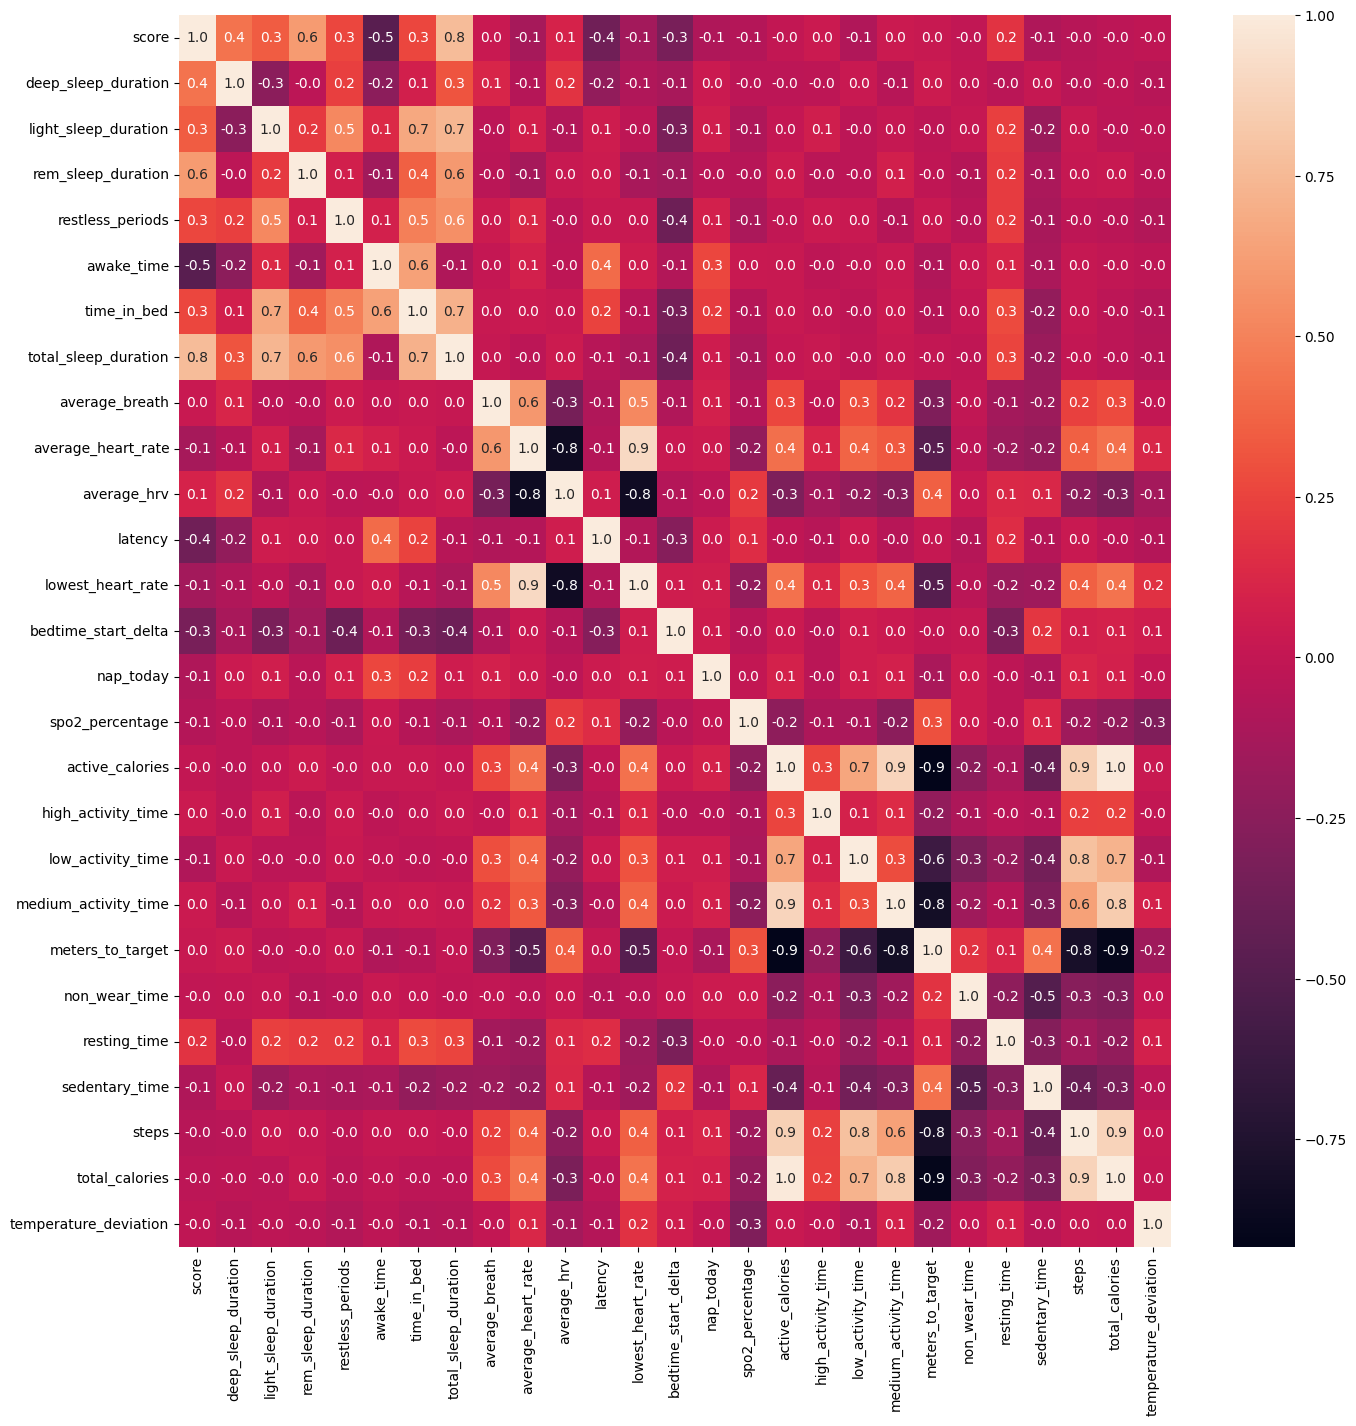

In [676]:
# Correlation
# Include score column to see correlation between response and predictors too.
corr_matrix = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1).corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.1f')

[ ANALYSIS HERE ]

Let's fit a linear regression model to the `['score']` response. This should help us identify important features and give a good idea how well our data will be in creating an accurate model.

In [677]:
# Create dataframe in the format usable for statsmodels >> ols()
ols_format_df = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1)

# Create predictors list for model
# Remove first column (score)
ols_predictors = (ols_format_df.columns[1:]).to_list()
ols_pred_string = ''
for i in ols_predictors:
    ols_pred_string = f'{ols_pred_string} + {i}'

linear_clf = smf.ols(formula = f'score ~ {ols_pred_string[3:]}', data = ols_format_df).fit()
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     94.95
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          7.51e-129
Time:                        18:34:02   Log-Likelihood:                -822.23
No. Observations:                 334   AIC:                             1696.
Df Residuals:                     308   BIC:                             1796.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -16.1615     31.345     -0.516      0.606     -77.838      45.515
deep_sleep_duration      -0.0005      0.001     -0.563      0.574      -0.002       0.001
light_sleep_duration     -0.0014      0.001     -1.448      0.149      -0.003       0.000
rem_sleep_duration    -5.424e-05      0.001     -0.057      0.954      -0.002       0.002
restless_periods         -0.0202      0.004     -4.707      0.000      -0.029      -0.012
awake_time               -0.0054      0.004     -1.432      0.153      -0.013       0.002
time_in_bed               0.0047      0.004      1.254      0.211      -0.003       0.012
total_sleep_duration     -0.0020      0.003     -0.694      0.488      -0.008       0.004
average_breath            0.5308      0.505      1.051      0.294      -0.463       1.524
average_heart_rate       -0.1130      0.073     -1.559      0.120      -0.256       0.030
average_hrv              -0.0129      0.015     -0.867      0.386      -0.042       0.016
latency                  -0.0021      0.000    -11.660      0.000      -0.002      -0.002
lowest_heart_rate         0.0072      0.062      0.117      0.907      -0.114       0.128
bedtime_start_delta      -0.0006   6.36e-05     -8.646      0.000      -0.001      -0.000
nap_today                -0.5965      0.563     -1.059      0.290      -1.705       0.512
spo2_percentage           0.3224      0.236      1.364      0.174      -0.143       0.787
active_calories          -0.0028      0.010     -0.275      0.783      -0.023       0.017
high_activity_time        0.0006      0.001      0.377      0.706      -0.002       0.003
low_activity_time        -0.0002      0.000     -0.752      0.453      -0.001       0.000
medium_activity_time     -0.0003      0.001     -0.664      0.507      -0.001       0.001
meters_to_target      -7.495e-05      0.000     -0.716      0.475      -0.000       0.000
non_wear_time           8.08e-05      0.000      0.630      0.529      -0.000       0.000
resting_time              0.0001      0.000      1.120      0.264   -9.64e-05       0.000
sedentary_time         7.258e-05      0.000      0.519      0.604      -0.000       0.000
steps                  1.701e-05      0.000      0.142      0.887      -0.000       0.000
total_calories            0.0077      0.009      0.813      0.417      -0.011       0.026
temperature_deviation     0.6534      0.883      0.740      0.460      -1.084       2.391
==============================================================================
Omnibus:                       20.522   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.711
Skew:                          -0.489   Prob(JB):                     1.58e-06
Kurtosis:                       3.981   Cond. No.                  

#### Feature Selection/Removal

In [678]:
# Remove sign on correlation score for comparison.
# TODO: This method arbitrarily selects the first feature (of the two with a high score)
#   that it comes across. Change this method to have an insight-based selection method.
#   Possibly a preference list.
corr_matrix_abs = corr_matrix.abs()
# Drop score from x and y axis.
corr_matrix_abs.drop('score', axis = 0, inplace = True)
corr_matrix_abs.drop('score', axis = 1, inplace = True)
# Mask off only one of the correlation triangles to avoid duplicates.
corr_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k = 1).astype(bool))
# Create list of features with correlation higher than a threshold.
# Threshold set to > 0.75
to_drop = [column for column in corr_triangle.columns if any(corr_triangle[column] > 0.7)]
print(to_drop)

['total_sleep_duration', 'average_hrv', 'lowest_heart_rate', 'medium_activity_time', 'meters_to_target', 'steps', 'total_calories']


For now let's manually remove features (see TODO note above).

In [679]:
choices_to_drop = [('average_hrv', 'average_heart_rate'), # average_heart
           ('lowest_heart_rate', 'average_hrv'), # average hrv
           ('medium_activity_time', 'active_calories'), # active
           ('meters_to_target', 'active_calories'), # both
           ('steps', 'alot'), # steps
           ('total_calories', 'alot')] # total calories

bio_sleep_df.drop(['lowest_heart_rate', 
                   'active_calories', 
                   'meters_to_target', 
                   'steps', 
                   'total_calories', 
                   'average_heart_rate', 
                   'time_in_bed', 
                   'total_sleep_duration'],
                  axis = 1, inplace = True)

<Axes: >

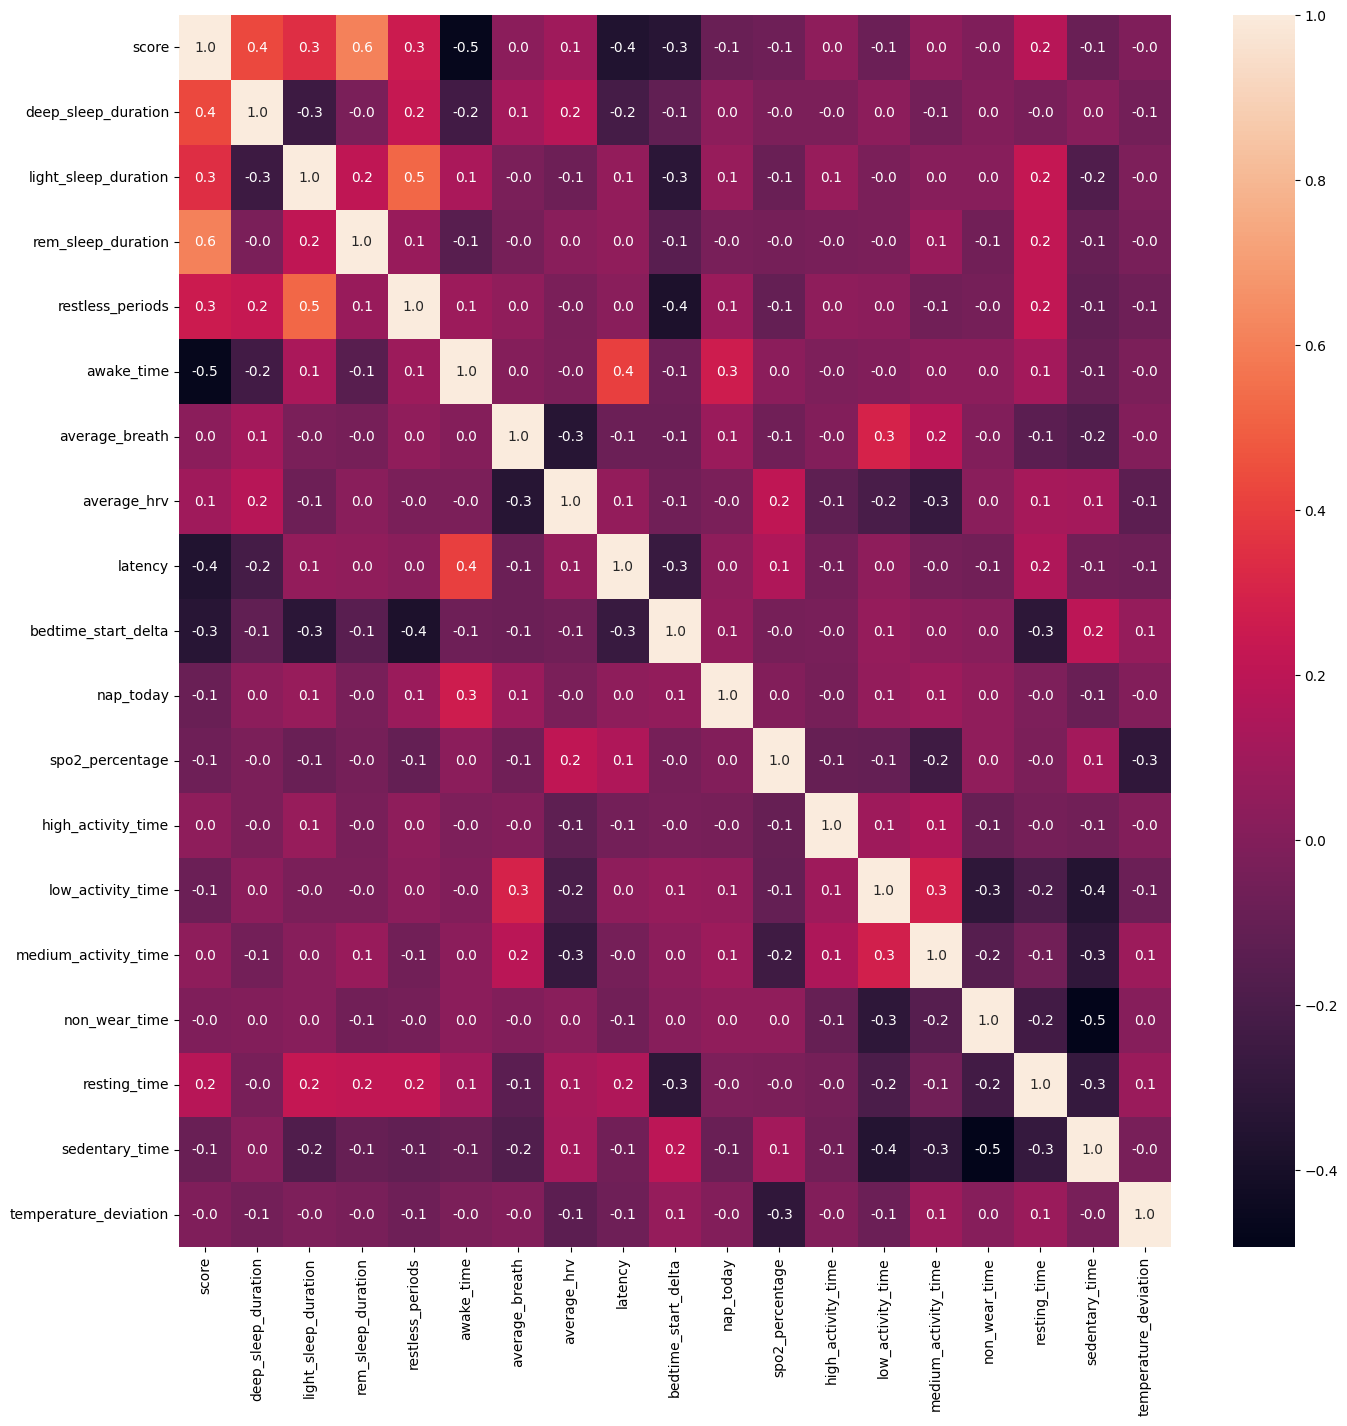

In [680]:
# Correlation
# Include score column to see correlation between response and predictors too.
corr_matrix = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1).corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.1f')

Subset Feature Selection / Backwards Feature Selection starting from all features.

In [681]:
# Move this about feature removal and maybe make yet another DF set for recursive optimization vs manual feature removal.

#### Outlier Removal

In [682]:
display(daily_sleep_score_df['score_bin'].value_counts())
# Remove outlier for now so we can class-balance the splits (min per class required = 2)
# TODO: Remove hardcoded solution, get counts and delete if == 1 in case of new data.
#       (Maybe use daily_sleep_score_df['score_bin'].value_counts() == 1)
class_outlier_loc = daily_sleep_score_df.loc[daily_sleep_score_df['score_bin'] == '35.5 to 40.5']
print(class_outlier_loc)
daily_sleep_score_df.drop(class_outlier_loc.index, axis = 0, inplace = True)
bio_sleep_df.drop(class_outlier_loc.index, axis = 0, inplace = True)

daily_sleep_score_df.reset_index(drop = True, inplace = True)
bio_sleep_df.reset_index(drop = True, inplace = True)

score_bin
75.5 to 80.5    86
80.5 to 85.5    72
70.5 to 75.5    69
65.5 to 70.5    41
85.5 to 90.5    26
60.5 to 65.5    24
55.5 to 60.5     7
90.5 to 95.5     3
45.5 to 50.5     3
40.5 to 45.5     2
35.5 to 40.5     1
Name: count, dtype: int64

     score     score_bin
285     36  35.5 to 40.5


#### Standardize Features
Since we'll be using many machine learning models in which regularization techniques are sensitive to differences in predictor variance magnitudes/scale (e.g., Lasso/Ridge Regression, SVM, etc.) and expect features to be roughly normally distributed, we will be standardizing features appropriately.

##### Train Test Split

Since we'll be using sklearn's StandardScaler() to standardize, we need to do the split at the same time so that we can properly separate the training information from the test set during standardization.

In total we will have 3 types of train / test splits to use on our models, but they will be split identically. We can also use the `stratify` parameter to class balance the training and test sets which will help generalize models training on this fairly sparse dataset.

In [683]:
rand_state = 9437285 #472453 #98784 # Used in all classifiers
test_ratio = 0.2
# Discretized Scores
# Stratify-balance the classes with the bin column.
X_train, X_test, y_train, y_test = train_test_split(bio_sleep_df, daily_sleep_score_df, 
                                                    test_size = test_ratio, 
                                                    random_state = rand_state, 
                                                    stratify = daily_sleep_score_df['score_bin'])

# Binned/Categorical Class Labels
y_train_bin, y_test_bin = y_train['score_bin'], y_test['score_bin']

# Centered and Standardized
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = scaler.get_feature_names_out())
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = scaler.get_feature_names_out())
# Squeeze y's to put into a series, same format as train_test_split
y_train_scaled = pd.DataFrame(scaler.fit_transform(np.array(y_train['score']).reshape(-1, 1)), columns = ['score_scaled']).squeeze(axis = 1)
y_test_scaled = pd.DataFrame(scaler.transform(np.array(y_test['score']).reshape(-1, 1)), columns = ['score_scaled']).squeeze(axis = 1)

# Create a centered and standardized DF for regression model.
bio_sleep_df_scaled = pd.DataFrame(scaler.fit_transform(bio_sleep_df), columns = scaler.get_feature_names_out())

daily_sleep_score_df['score_scaled'] = (pd.DataFrame(scaler.fit_transform(np.array(daily_sleep_score_df['score']).reshape(-1, 1))))
display(daily_sleep_score_df)

,score,score_bin,score_scaled
0,81,80.5 to 85.5,0.641282
1,81,80.5 to 85.5,0.641282
2,89,85.5 to 90.5,1.629353
3,78,75.5 to 80.5,0.270755
4,80,75.5 to 80.5,0.517773
...,...,...,...
328,77,75.5 to 80.5,0.147246
329,85,80.5 to 85.5,1.135317
330,64,60.5 to 65.5,-1.458369
331,77,75.5 to 80.5,0.147246


After standardization and feature removal let's see if the regression has changed.

In [684]:
# Create dataframe in the format usable for statsmodels >> ols()
ols_format_df_scaled = pd.concat([daily_sleep_score_df['score_scaled'], bio_sleep_df_scaled], axis = 1)

ols_predictors = (ols_format_df_scaled.columns[1:]).to_list()
ols_pred_string = ''
for i in ols_predictors:
    ols_pred_string = f'{ols_pred_string} + {i}'

linear_clf = smf.ols(formula = f'score_scaled ~ {ols_pred_string[3:]}', data = ols_format_df_scaled).fit()
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           score_scaled   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     123.3
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          1.66e-130
Time:                        18:34:03   Log-Likelihood:                -124.82
No. Observations:                 333   AIC:                             287.6
Df Residuals:                     314   BIC:                             360.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.476e-16      0.020   1.75e-14      1.000      -0.039       0.039
deep_sleep_duration       0.4394      0.025     17.450      0.000       0.390       0.489
light_sleep_duration      0.4140      0.028     14.913      0.000       0.359       0.469
rem_sleep_duration        0.4868      0.022     22.551      0.000       0.444       0.529
restless_periods         -0.1368      0.027     -4.978      0.000      -0.191      -0.083
awake_time               -0.2390      0.023    -10.328      0.000      -0.285      -0.193
average_breath            0.0050      0.023      0.218      0.827      -0.040       0.050
average_hrv               0.0227      0.023      0.979      0.328      -0.023       0.068
latency                  -0.2745      0.024    -11.606      0.000      -0.321      -0.228
bedtime_start_delta      -0.2276      0.025     -9.075      0.000      -0.277      -0.178
nap_today                -0.0104      0.021     -0.496      0.620      -0.052       0.031
spo2_percentage           0.0316      0.022      1.426      0.155      -0.012       0.075
high_activity_time        0.0291      0.022      1.332      0.184      -0.014       0.072
low_activity_time         0.0029      0.070      0.041      0.967      -0.136       0.141
medium_activity_time      0.0607      0.036      1.703      0.090      -0.009       0.131
non_wear_time             0.0741      0.092      0.806      0.421      -0.107       0.255
resting_time              0.0817      0.064      1.274      0.203      -0.044       0.208
sedentary_time            0.0902      0.099      0.910      0.364      -0.105       0.285
temperature_deviation     0.0159      0.021      0.739      0.460      -0.026       0.058
==============================================================================
Omnibus:                       21.690   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.866
Skew:                          -0.535   Prob(JB):                     1.47e-06
Kurtosis:                       3.890   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[ ANALYSIS ]

Note the condition number! Standardization and removal of features made quite the difference in multicollinearity there.

### Helper Functions

In [685]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['max_depth']), len(grid.param_grid['max_leaf_nodes']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('max_depth')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['max_leaf_nodes'])), grid.param_grid['max_leaf_nodes'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['max_depth'])), grid.param_grid['max_depth'])
    plt.title('Validation accuracy')
    plt.show()

def plotSearchGridSVM(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['C']), len(grid.param_grid['gamma']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['gamma'])), grid.param_grid['gamma'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['C'])), grid.param_grid['C'])
    plt.title('Validation accuracy')
    plt.show()

### Model Selection

#### Linear Regression / Logistic Classification

In [686]:
clf_log_regression = LogisticRegression(solver = 'sag', max_iter = 10000, random_state = rand_state).fit(X_train, y_train_bin)
print(clf_log_regression.score(X_test, y_test_bin))

clf_lin_regression = LinearRegression().fit(X_train, y_train['score'])
print(clf_lin_regression.score(X_test, y_test['score']))

clf_ridge_regression = Ridge(max_iter = 10000, random_state = rand_state).fit(X_train, y_train['score'])
print(clf_ridge_regression.score(X_test, y_test['score']))

clf_lasso_regression = Lasso(max_iter = 10000, random_state = rand_state).fit(X_train, y_train['score'])
print(clf_lasso_regression.score(X_test, y_test['score']))

0.5373134328358209
0.8192849174071891
0.8195159946618076
0.8231377879910535


In [687]:
from sklearn.linear_model import RidgeClassifier

clf_lasso_regression = RidgeClassifier(max_iter = 10000, random_state = rand_state).fit(X_train, y_train_bin)
print(clf_lasso_regression.score(X_test, y_test_bin))

0.34328358208955223


#### Support Vector Machine (SVM)

In [688]:
from sklearn.svm import SVR
params = {'C': np.logspace(6, 10, base = 2), 'gamma': np.logspace(-10, 0, base = 2)}
grid_svm = GridSearchCV(SVR(kernel = 'rbf'), param_grid = params, cv = 3).fit(X_train_scaled, y_train['score'])

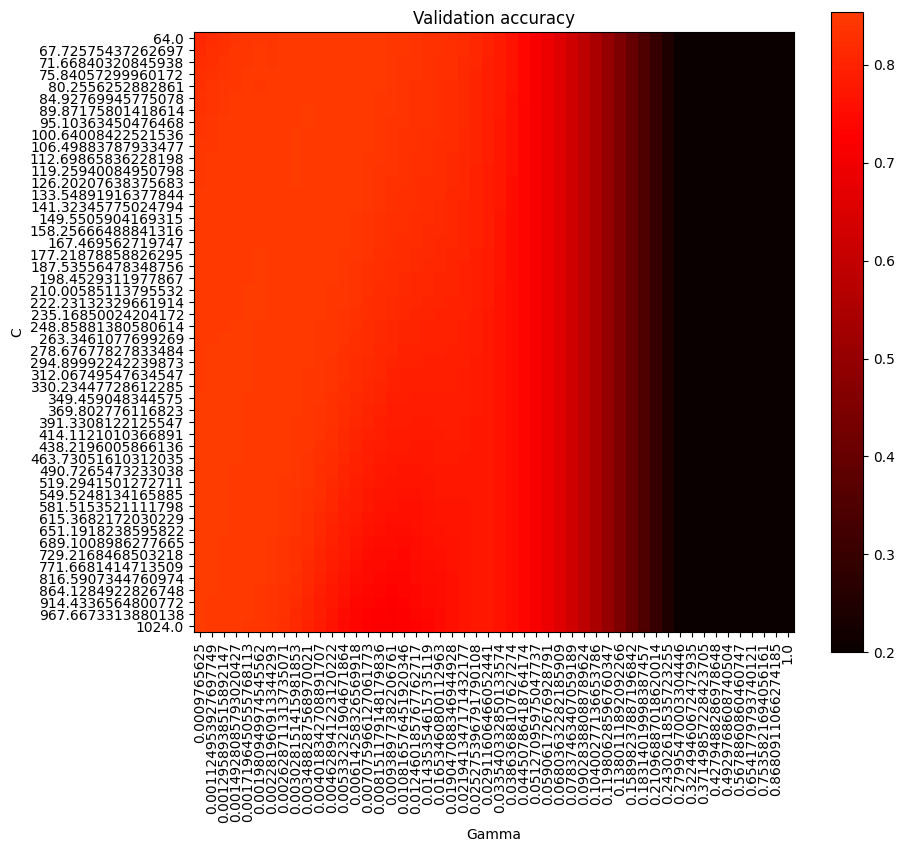

In [689]:
plotSearchGridSVM(grid_svm)

GridSearch results indicate the optimized parameters are, 
C: 689.1008986277665, Gamma: 0.0009765625, Accuracy: 0.85376974440447
0.9402985074626866


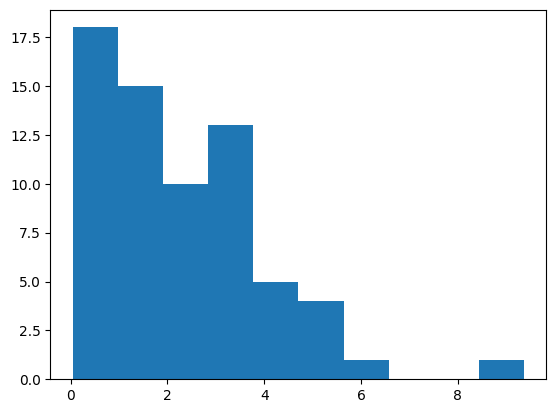

In [690]:
scores = [x for x in grid_svm.cv_results_["mean_test_score"]]

max_index = scores.index(max(scores))
max_score = max(scores)
opt_C = grid_svm.cv_results_['param_C'][max_index]
opt_Gamma = grid_svm.cv_results_['param_gamma'][max_index]

print(f'GridSearch results indicate the optimized parameters are, \nC: {opt_C}, Gamma: {opt_Gamma}, Accuracy: {max_score}')

# OR use the attribute .best_params_
grid_svm.best_params_

results_svm = list(zip(grid_svm.predict(X_test_scaled), y_test['score']))
pred_delta_svm = [abs(pred - truth) for pred, truth in results_svm]
plt.hist(pred_delta_svm)
print((np.array(pred_delta_svm) <= 5).sum() / len(pred_delta_svm))

#### Decision Trees

In [691]:
dt = DecisionTreeClassifier(max_depth = None, max_leaf_nodes = None, random_state = rand_state).fit(X_train, y_train['score'])
print(dt.score(X_train, y_train['score']))
print(dt.score(X_test, y_test['score']))
#path = dt.cost_complexity_pruning_path(X_train, y_train)
#ccp_alphas, impurities = path.ccp_alphas, path.impurities

1.0
0.04477611940298507


##### AdaBoost

---



0.07462686567164178
0.6417910447761194


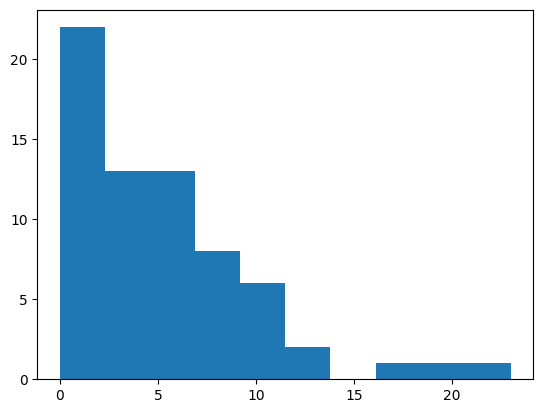

In [692]:
adaboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),
                   n_estimators = 100,
                   random_state = rand_state,
                   learning_rate = 0.5
                   ).fit(X_train, y_train['score'])
print(adaboost_clf.score(X_test, y_test['score']))
results_adaboost = list(zip(adaboost_clf.predict(X_test), y_test['score']))
pred_delta_adaboost = [abs(pred - truth) for pred, truth in results_adaboost]
plt.hist(pred_delta_adaboost)
print((np.array(pred_delta_adaboost) <= 5).sum() / len(pred_delta_adaboost))

##### Random Forest

---


In [693]:
params = {'max_depth': np.linspace(1, 25, 25, dtype = int), 'max_leaf_nodes': np.linspace(2, 98, 25, dtype = int)}
grid = GridSearchCV(RandomForestClassifier(random_state=rand_state), 
                    param_grid = params, 
                    cv = 3, 
                    verbose = 3, 
                    n_jobs = -1
                    ).fit(X_train, y_train['score'])

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


[CV 2/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.067 total time=   0.1s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.067 total time=   0.1s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.090 total time=   0.1s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.068 total time=   0.1s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.090 total time=   0.1s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.068 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.090 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.068 total time=   0.0s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.067 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.090 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.067 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.090 total time=   0.1s
[CV 3/3] END ....max_depth=1

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 2/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.067 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.068 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=22;, score=0.090 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=22;, score=0.067 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=26;, score=0.068 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=26;, score=0.090 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=34;, score=0.068 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=34;, score=0.090 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=42;, score=0.090 total time=   0.0s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=30;, score=0.067 total time=   0.2s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=22;, score=0.068 total time=   0.0s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=38;, score=0.067 total time=   0.1s
[CV 2/3] END ....max_depth=1

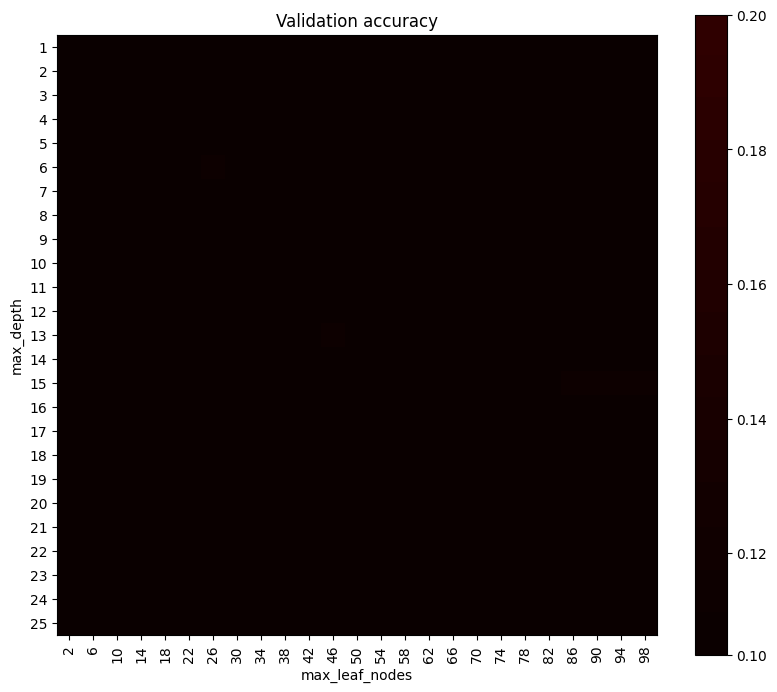

In [694]:
plotSearchGrid(grid)

0.014925373134328358


0.7014925373134329

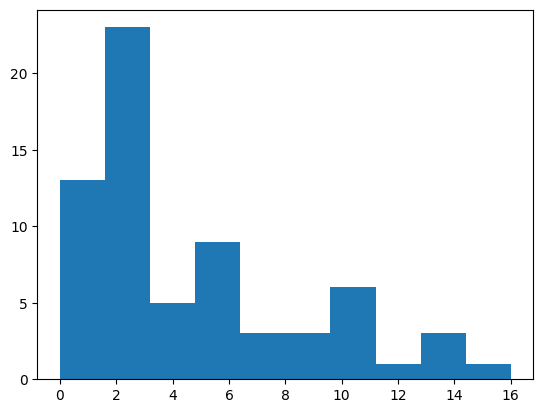

In [695]:
results_rand_forest = list(zip(grid.best_estimator_.predict(X_test), y_test['score']))
print(grid.best_estimator_.score(X_test, y_test['score']))

pred_delta_rand_forest = [abs(pred - truth) for pred, truth in results_rand_forest]
plt.hist(pred_delta_rand_forest)
(np.array(pred_delta_rand_forest) <= 5).sum() / len(pred_delta_rand_forest)

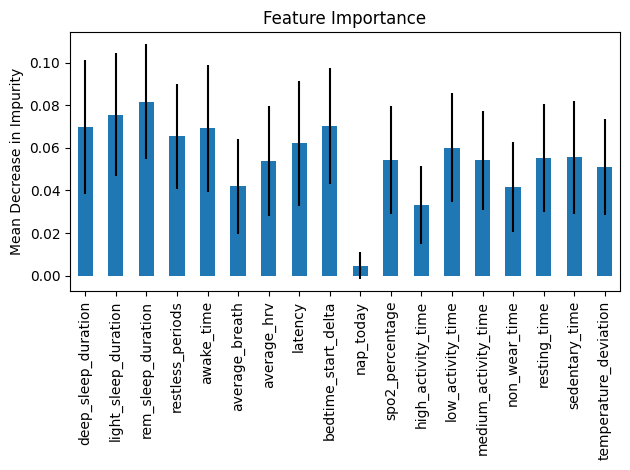

In [696]:
feat_importance = grid.best_estimator_.feature_importances_
feat_imp_std = np.std([tree.feature_importances_ for tree in grid.best_estimator_.estimators_], axis = 0)
forest_importances = pd.Series(feat_importance, index=bio_sleep_df.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = feat_imp_std, ax = ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

In [697]:
grid.best_estimator_

RandomForestClassifier(max_depth=15, max_leaf_nodes=86, random_state=9437285)

In [698]:
cm = confusion_matrix(y_test, grid.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = sorted(y_test.unique()))
disp.plot()
plt.xticks(rotation=90)
plt.show()

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
results_bins = (grid.best_estimator_.predict(X_test))
results_bins[0]

83

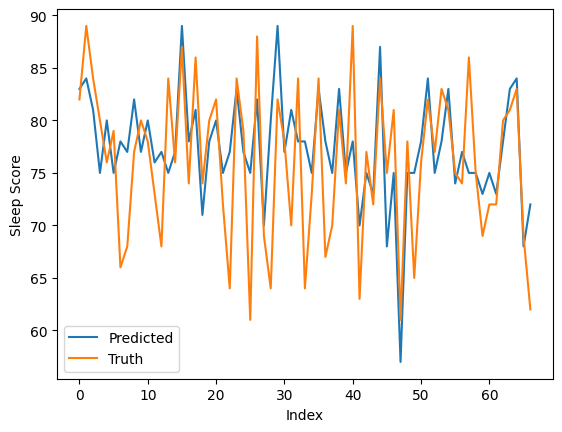

In [ ]:
plt.plot(results_rand_forest, label = ['Predicted', 'Truth'])
plt.xlabel('Index')
plt.ylabel('Sleep Score')
plt.plot()
plt.legend()

### Results

---

